# Train and Test Data Processing

### Notebook Overview

This notebook is part of the **Balancium Rx** project, which aims to develop a machine learning model to predict drug-drug interactions. The notebook automates the data processing pipeline by:  
1. **Input Handling:** Reading and consolidating data from multiple CSV files.  
2. **Data Cleaning:** Addressing missing values and inconsistencies to ensure data quality.  
3. **Feature Engineering:** Creating and transforming features tailored for machine learning models.  
4. **Output Preparation:** Generating well-structured, machine-learning-ready CSV files compatible with Python libraries like scikit-learn.  

By the end of this notebook, the processed data will be ready for model development, enabling the creation of predictive models that contribute to safer drug administration and interaction analysis.

---

### Summary of Input CSV Files

This notebook utilizes the following input CSV files to prepare the data for the **Balancium Rx** project:  

1. **`ddinter_downloads_code_A.csv`**  
   - **Description:** Contains information about drug-drug interaction pairs for drugs involved in alimentary tract and metabolism drugs.  
   - **Source:** DDinter Database: [DDinter Downloads](https://ddinter.scbdd.com/static/media/download/ddinter_downloads_code_A.csv)  
   - **Key Columns:**  
     - **Drug_A:** Drug name for the first drug  
     - **Drug_B:** Drug name for the second drug  
     - **Level:** Level of interaction between the two drugs, categorized into:  
        1. Unknown  
        2. Minor  
        3. Moderate  
        4. Major  

2. **`pubchem_data.csv`**  
   - **Description:** Includes chemical properties and features derived from PubChem for the drugs involved in the dataset.  
   - **Source:** Results of a query run on [PubChem](https://pubchem.ncbi.nlm.nih.gov/) with a list of CID values outputted by the `ddinter_data_processing.ipynb` Jupyter Notebook.  
   - **Key Columns and Descriptions:**  

     - **`cid`:** PubChem Compound Identifier (CID), a unique numeric identifier for chemical substances in PubChem.  
     - **`mw`:** Molecular Weight, the average mass of the molecule based on the weighted average of isotopic masses.  
     - **`polararea`:** Polar Surface Area (PSA), the surface area of polar atoms and their attached hydrogens, indicating drug absorption.  
     - **`complexity`:** A numerical representation of the structural complexity of the molecule.  
     - **`xlogp`:** LogP value, a measure of a compound's lipophilicity (fat solubility).  
     - **`heavycnt`:** Heavy Atom Count, the number of non-hydrogen atoms in the molecule.  
     - **`hbonddonor`:** Hydrogen Bond Donor Count, the number of hydrogen atoms that can participate in hydrogen bonding.  
     - **`hbondacc`:** Hydrogen Bond Acceptor Count, the number of atoms that can accept hydrogen bonds.  
     - **`rotbonds`:** Rotatable Bonds Count, the number of single non-ring bonds allowing free rotation.  
     - **`exactmass`:** Exact Mass, the precise mass of the most abundant isotope of each atom in the molecule.  
     - **`monoisotopicmass`:** Monoisotopic Mass, the mass of the molecule using the most abundant isotope for each element.  
     - **`charge`:** Net molecular charge, indicating the overall electrical charge of the molecule.  
     - **`covalentunitcnt`:** Covalent Unit Count, the number of covalently bonded units in the molecule.  
     - **`isotopeatomcnt`:** Isotope Atom Count, the number of atoms that are isotopes.  
     - **`totalatomstereocnt`:** Total Atom Stereocenter Count, the number of chiral centers in the molecule.  
     - **`definedatomstereocnt`:** Defined Atom Stereocenter Count, the number of stereocenters with explicitly defined configurations.  
     - **`undefinedatomstereocnt`:** Undefined Atom Stereocenter Count, the number of stereocenters without defined configurations.  
     - **`totalbondstereocnt`:** Total Bond Stereocenter Count, the number of stereocenters arising from double bonds in the molecule.  
     - **`definedbondstereocnt`:** Defined Bond Stereocenter Count, the number of bond stereocenters with explicitly defined configurations.  
     - **`undefinedbondstereocnt`:** Undefined Bond Stereocenter Count, the number of bond stereocenters without defined configurations.  
   
  3. **`drug_cids.csv`**  
  - **Description:** A mapping file that associates drug names or identifiers with their corresponding PubChem Compound Identifiers (CIDs) to used as a link table between `ddinter_downloads_code_A.csv`and `pubchem_data.csv`.
  - **Source:** Output file from the `ddinter_data_processing.ipynb` Jupyter Notebook.  
  - **Key Columns:**  
    - **Drug Name:** Drug name as featured in `ddinter_downloads_code_A.csv`.  
    - **CID:** Primary key used in the PubChem database.  

These datasets collectively provide the foundational information required to process and prepare the data for predicting drug-drug interactions.  

---
### Exploratory Data Analysis

#### Data Loading

In [75]:
# Loading libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [76]:
# File paths
ddinter_path = "data/ddinter_downloads_code_A.csv"
drug_cids_path = "data/drug_cids.csv"
pubchem_path = "data/pubchem_data.csv"

In [77]:
# Load DataFrames
ddinter_df = pd.read_csv(ddinter_path)
drug_cids_df = pd.read_csv(drug_cids_path)
pubchem_df = pd.read_csv(pubchem_path)

#### Drug Name - CID Data Processing

We rename the 'CIDs' column to 'cid' for easier joins later. This DataFrame is meant to be a link table for joining the other two DataFrames.

In [78]:
drug_cids_df.head()


,Drug Name,CIDs
0,Naltrexone,4428.0
1,Naltrexone,5360515.0
2,Naltrexone,5702239.0
3,Naltrexone,6321302.0
4,Naltrexone,6604527.0


In [79]:
# Rename 'CIDs' to 'cid' in drug_cids_df before any join
drug_cids_df.rename(columns={'CIDs': 'cid'}, inplace=True)

# Check the first few rows to ensure the column is renamed
drug_cids_df.head()


,Drug Name,cid
0,Naltrexone,4428.0
1,Naltrexone,5360515.0
2,Naltrexone,5702239.0
3,Naltrexone,6321302.0
4,Naltrexone,6604527.0


In [80]:
drug_cids_df.shape

(11783, 2)

In [81]:
# Count the number of missing CID values
missing_cids = drug_cids_df['cid'].isna().sum()
missing_cids

274

In [82]:
# Drop the rows with missing CID values
drug_cids_df.dropna(subset=['cid'], inplace=True)


In [83]:
# Count the number of unique CID values per Drug Name
cids_per_drug = drug_cids_df.groupby(['Drug Name']).agg(cid_nunique=('cid', 'nunique')).reset_index()
cids_per_drug.head()

,Drug Name,cid_nunique
0,Abacavir,18
1,Abaloparatide,5
2,Abarelix,7
3,Abciximab,1
4,Abemaciclib,5


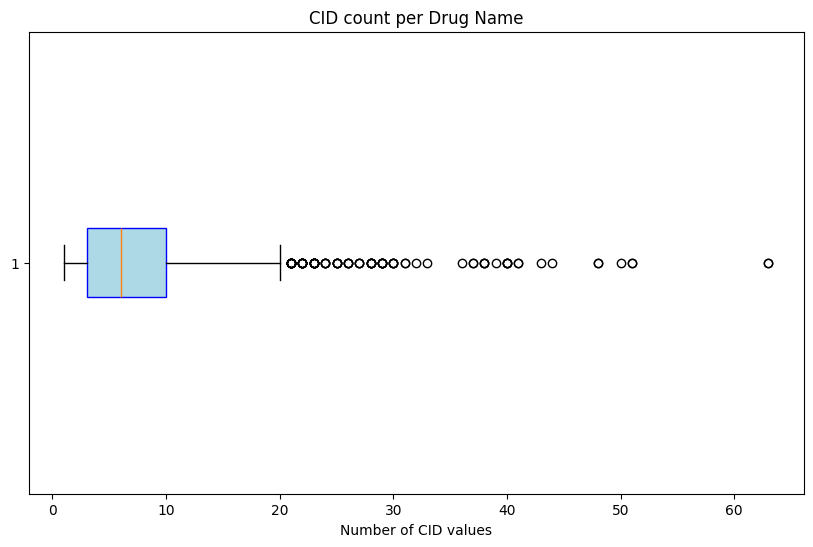

In [84]:
# Make a box plot to visualize the distribution
import matplotlib.pyplot as plt

# Boxplot for the 'values' column
plt.figure(figsize=(10, 6))
plt.boxplot(cids_per_drug['cid_nunique'], vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue', color='blue'))

# Add labels and title
plt.xlabel('Number of CID values')
plt.title('CID count per Drug Name')

# Display the plot
plt.show()


#### DDinter Data Processing

We keep the relevant columns for future joins.
We apply a mapping to the Level column values to use integers as ordered factors.

In [85]:
# Show the first few rows to check the data
ddinter_df.head()

,DDInterID_A,Drug_A,DDInterID_B,Drug_B,Level
0,DDInter1263,Naltrexone,DDInter1,Abacavir,Moderate
1,DDInter1,Abacavir,DDInter1348,Orlistat,Moderate
2,DDInter58,Aluminum hydroxide,DDInter582,Dolutegravir,Major
3,DDInter112,Aprepitant,DDInter582,Dolutegravir,Minor
4,DDInter138,Attapulgite,DDInter582,Dolutegravir,Major


In [86]:
# Keep only the relevant columns: 'Drug_A', 'Drug_B', and 'Level'
ddinter_df = ddinter_df[['Drug_A', 'Drug_B', 'Level']]

# Display the filtered DataFrame
ddinter_df.head()


,Drug_A,Drug_B,Level
0,Naltrexone,Abacavir,Moderate
1,Abacavir,Orlistat,Moderate
2,Aluminum hydroxide,Dolutegravir,Major
3,Aprepitant,Dolutegravir,Minor
4,Attapulgite,Dolutegravir,Major


In [87]:
# Drop rows where 'Level' is 'Unknown'
ddinter_df = ddinter_df[ddinter_df['Level'] != 'Unknown']

# Map 'Level' column from factors (strings) to integers
level_mapping = {'Minor': 0, 'Moderate': 1, 'Major': 2}
ddinter_df['Level'] = ddinter_df['Level'].map(level_mapping)

# Ensure 'Level' is of integer type for scikit-learn
ddinter_df['Level'] = ddinter_df['Level'].astype(int)

# Display the updated 'Level' column
ddinter_df[['Drug_A', 'Drug_B', 'Level']].head()


,Drug_A,Drug_B,Level
0,Naltrexone,Abacavir,1
1,Abacavir,Orlistat,1
2,Aluminum hydroxide,Dolutegravir,2
3,Aprepitant,Dolutegravir,0
4,Attapulgite,Dolutegravir,2


In [88]:
# Group by Level and count the number of rows for each one
level_count = ddinter_df.groupby('Level').size().reset_index(name='count')

level_count

,Level,count
0,0,3637
1,1,33057
2,2,4906


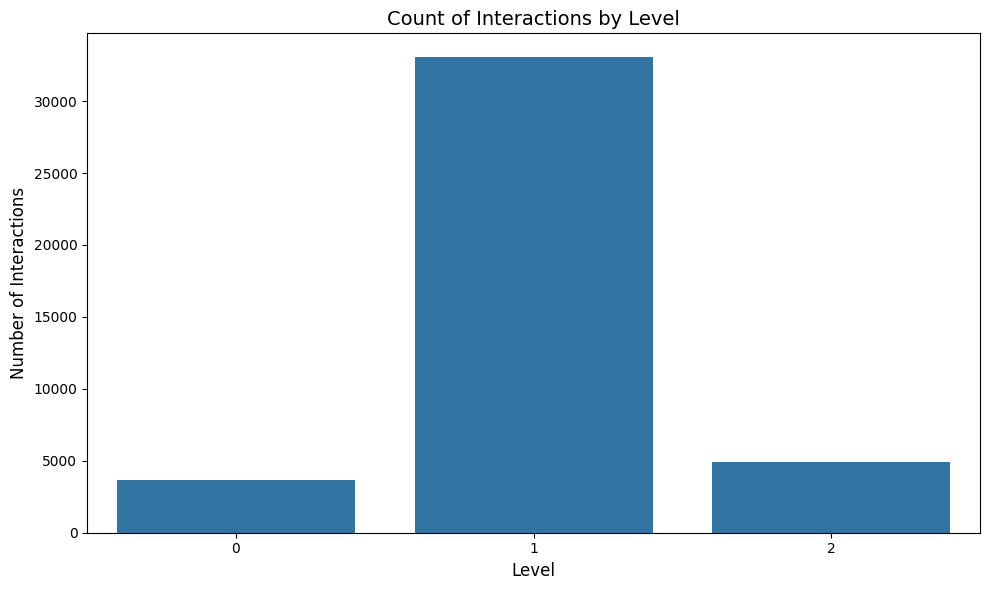

In [89]:
# Assuming level_count is already defined
plt.figure(figsize=(10, 6))
sns.barplot(data=level_count, x='Level', y='count')

# Add titles and labels
plt.title('Count of Interactions by Level', fontsize=14)
plt.xlabel('Level', fontsize=12)
plt.ylabel('Number of Interactions', fontsize=12)

# Show plot
plt.tight_layout()
plt.show()


#### PubChem Query Results Data Processing

We keep only the relevant molecular properties and forego of many columns containing foreign keys or chemical structure.

In [90]:
pubchem_df.head()


,cid,cmpdname,cmpdsynonym,mw,mf,polararea,complexity,xlogp,heavycnt,hbonddonor,...,gpidcnt,gpfamilycnt,meshheadings,annothits,annothitcnt,aids,cidcdate,sidsrcname,depcatg,annotation
0,4428,"3-(cyclopropylmethyl)-4a,9-dihydroxy-2,4,5,6,7...","3-(cyclopropylmethyl)-4a,9-dihydroxy-2,4,5,6,7...",341.4,C20H23NO4,70.0,621.0,1.9,25,2,...,76,32,NaN,Biological Test Results|Classification|Literat...,6,2063|624101|624136|624137|624138|624139|624141...,20050325,ABI Chem|AKos Consulting & Solutions|Angel Pha...,Chemical Vendors|Curation Efforts|Governmental...,NaN
1,5360515,Naltrexone,naltrexone|16590-41-3|Vivitrex|Vivitrol|ReVia|...,341.4,C20H23NO4,70.0,621.0,1.9,25,2,...,41424,8081,Naltrexone,Biological Test Results|Interactions and Pathw...,17,1332|2240|2241|2275|2313|2316|2322|2330|2517|2...,20050624,"001Chemical|3WAY PHARM INC|A&J Pharmtech CO., ...",Chemical Vendors|Curation Efforts|Governmental...,C78272 - Agent Affecting Nervous System > C681...
2,5702239,"(4R,4aS,7aR)-3-(cyclopropylmethyl)-4a,9-dihydr...",Spectrum_001645|Spectrum2_001547|Spectrum3_001...,341.4,C20H23NO4,70.0,621.0,1.9,25,2,...,12,10,NaN,Biological Test Results|Classification|Patents...,4,940|1422|1580|1581|1582|1583|1584|1585|1586|15...,20060307,Broad Institute|Burnham Center for Chemical Ge...,Chemical Vendors|Curation Efforts|Governmental...,NaN
3,6321302,Tocris-0677,Tocris-0677|Lopac-N-3136|CHEMBL1437711|NCGC000...,341.4,C20H23NO4,70.0,621.0,1.9,25,2,...,0,0,NaN,Biological Test Results|Biological Test Result...,3,357|410|411|444|445|446|447|448|450|451|526|53...,20050629,ChEMBL|ChemSpider|MolGenie|National Center for...,Chemical Vendors|Curation Efforts|Governmental...,NaN
4,6604527,"(4R,4aR,7aS,12bS)-3-(cyclopropylmethyl)-4a,9-d...",CHEMBL1625662|NCGC00018224-01,341.4,C20H23NO4,70.0,621.0,1.9,25,2,...,0,0,NaN,NaN,0,NaN,20060530,ChEMBL|ChemSpider|MolGenie|National Center for...,Chemical Vendors|Curation Efforts|Governmental...,NaN


In [91]:
pubchem_df.dtypes

cid                         int64
cmpdname                   object
cmpdsynonym                object
mw                        float64
mf                         object
polararea                 float64
complexity                float64
xlogp                     float64
heavycnt                    int64
hbonddonor                  int64
hbondacc                    int64
rotbonds                    int64
inchi                      object
isosmiles                  object
canonicalsmiles            object
inchikey                   object
iupacname                  object
exactmass                 float64
monoisotopicmass          float64
charge                      int64
covalentunitcnt             int64
isotopeatomcnt              int64
totalatomstereocnt          int64
definedatomstereocnt        int64
undefinedatomstereocnt      int64
totalbondstereocnt          int64
definedbondstereocnt        int64
undefinedbondstereocnt      int64
pclidcnt                    int64
gpidcnt       

In [92]:
# Drop non-relevant columns and keep only the 'cid' column and molecular descriptors
columns_to_keep = [
    'cid', 'mw', 'polararea', 'complexity', 'xlogp', 'heavycnt', 
    'hbonddonor', 'hbondacc', 'rotbonds', 'exactmass', 'monoisotopicmass', 
    'charge', 'covalentunitcnt', 'isotopeatomcnt', 'totalatomstereocnt', 
    'definedatomstereocnt', 'undefinedatomstereocnt', 'totalbondstereocnt', 
    'definedbondstereocnt', 'undefinedbondstereocnt'
]

# Filter the pubchem_df by keeping only the required columns
pubchem_df = pubchem_df[columns_to_keep]

# Display the filtered pubchem_df
pubchem_df.head()


,cid,mw,polararea,complexity,xlogp,heavycnt,hbonddonor,hbondacc,rotbonds,exactmass,monoisotopicmass,charge,covalentunitcnt,isotopeatomcnt,totalatomstereocnt,definedatomstereocnt,undefinedatomstereocnt,totalbondstereocnt,definedbondstereocnt,undefinedbondstereocnt
0,4428,341.4,70.0,621.0,1.9,25,2,5,2,341.163,341.163,0,1,0,4,0,4,0,0,0
1,5360515,341.4,70.0,621.0,1.9,25,2,5,2,341.163,341.163,0,1,0,4,4,0,0,0,0
2,5702239,341.4,70.0,621.0,1.9,25,2,5,2,341.163,341.163,0,1,0,4,3,1,0,0,0
3,6321302,341.4,70.0,621.0,1.9,25,2,5,2,341.163,341.163,0,1,0,4,4,0,0,0,0
4,6604527,341.4,70.0,621.0,1.9,25,2,5,2,341.163,341.163,0,1,0,4,4,0,0,0,0


In [93]:
# Drop non-numerical columns from pubchem_df
pubchem_df = pubchem_df.select_dtypes(include=['number'])

# Show the first few rows of the cleaned pubchem_df
pubchem_df.head()


,cid,mw,polararea,complexity,xlogp,heavycnt,hbonddonor,hbondacc,rotbonds,exactmass,monoisotopicmass,charge,covalentunitcnt,isotopeatomcnt,totalatomstereocnt,definedatomstereocnt,undefinedatomstereocnt,totalbondstereocnt,definedbondstereocnt,undefinedbondstereocnt
0,4428,341.4,70.0,621.0,1.9,25,2,5,2,341.163,341.163,0,1,0,4,0,4,0,0,0
1,5360515,341.4,70.0,621.0,1.9,25,2,5,2,341.163,341.163,0,1,0,4,4,0,0,0,0
2,5702239,341.4,70.0,621.0,1.9,25,2,5,2,341.163,341.163,0,1,0,4,3,1,0,0,0
3,6321302,341.4,70.0,621.0,1.9,25,2,5,2,341.163,341.163,0,1,0,4,4,0,0,0,0
4,6604527,341.4,70.0,621.0,1.9,25,2,5,2,341.163,341.163,0,1,0,4,4,0,0,0,0


---
### Table Join

We perform DataFrame Merges (Table Joins) to obtain a table that features predictors taken from the `pubchem_df`for both drugs on the `ddinter_df` DataFrame to be used for machine learning modeling.

In [94]:
# Merge drug_cids_df with pubchem_df on 'cid' for Drug_A
ddinter_drugA_joined = pd.merge(ddinter_df, drug_cids_df, left_on='Drug_A', right_on='Drug Name', how='inner')

# Merge with pubchem_df on 'cid' for Drug_A
ddinter_drugA_joined = pd.merge(ddinter_drugA_joined, pubchem_df, on='cid', how='inner')

# Rename columns for Drug_A (add _A suffix)
drug_a_columns = ['cid'] + list(pubchem_df.columns)  # cid and all the numerical properties from pubchem_df
ddinter_drugA_joined = ddinter_drugA_joined.rename(columns={col: f"{col}_A" for col in drug_a_columns})

# Display the result
ddinter_drugA_joined.head()


,Drug_A,Drug_B,Level,Drug Name,cid_A,mw_A,polararea_A,complexity_A,xlogp_A,heavycnt_A,...,monoisotopicmass_A,charge_A,covalentunitcnt_A,isotopeatomcnt_A,totalatomstereocnt_A,definedatomstereocnt_A,undefinedatomstereocnt_A,totalbondstereocnt_A,definedbondstereocnt_A,undefinedbondstereocnt_A
0,Naltrexone,Abacavir,1,Naltrexone,4428.0,341.4,70.0,621.0,1.9,25,...,341.163,0,1,0,4,0,4,0,0,0
1,Naltrexone,Abacavir,1,Naltrexone,5360515.0,341.4,70.0,621.0,1.9,25,...,341.163,0,1,0,4,4,0,0,0,0
2,Naltrexone,Abacavir,1,Naltrexone,5702239.0,341.4,70.0,621.0,1.9,25,...,341.163,0,1,0,4,3,1,0,0,0
3,Naltrexone,Abacavir,1,Naltrexone,6321302.0,341.4,70.0,621.0,1.9,25,...,341.163,0,1,0,4,4,0,0,0,0
4,Naltrexone,Abacavir,1,Naltrexone,6604527.0,341.4,70.0,621.0,1.9,25,...,341.163,0,1,0,4,4,0,0,0,0


In [95]:
# Merge drug_cids_df with pubchem_df on 'cid' for Drug_B
ddinter_drugA_drugB_joined = pd.merge(ddinter_drugA_joined, drug_cids_df, left_on='Drug_B', right_on='Drug Name', how='inner')

# Merge with pubchem_df on 'cid' for Drug_B
ddinter_drugA_drugB_joined = pd.merge(ddinter_drugA_drugB_joined, pubchem_df, on='cid', how='inner')

# Rename columns for Drug_B (add _B suffix)
drug_b_columns = ['cid'] + list(pubchem_df.columns)  # cid and all the numerical properties from pubchem_df
ddinter_drugA_drugB_joined = ddinter_drugA_drugB_joined.rename(columns={col: f"{col}_B" for col in drug_b_columns})

# Display the result
ddinter_drugA_drugB_joined.head()


,Drug_A,Drug_B,Level,Drug Name_x,cid_A,mw_A,polararea_A,complexity_A,xlogp_A,heavycnt_A,...,monoisotopicmass_B,charge_B,covalentunitcnt_B,isotopeatomcnt_B,totalatomstereocnt_B,definedatomstereocnt_B,undefinedatomstereocnt_B,totalbondstereocnt_B,definedbondstereocnt_B,undefinedbondstereocnt_B
0,Naltrexone,Abacavir,1,Naltrexone,4428.0,341.4,70.0,621.0,1.9,25,...,286.154,0,1,0,2,0,2,0,0,0
1,Naltrexone,Abacavir,1,Naltrexone,4428.0,341.4,70.0,621.0,1.9,25,...,286.154,0,1,0,2,1,1,0,0,0
2,Naltrexone,Abacavir,1,Naltrexone,4428.0,341.4,70.0,621.0,1.9,25,...,384.122,0,2,0,2,1,1,0,0,0
3,Naltrexone,Abacavir,1,Naltrexone,4428.0,341.4,70.0,621.0,1.9,25,...,286.154,0,1,0,2,2,0,0,0,0
4,Naltrexone,Abacavir,1,Naltrexone,4428.0,341.4,70.0,621.0,1.9,25,...,670.276,0,3,0,4,4,0,0,0,0


In [96]:
# Change the datatype of 'cid_A' and 'cid_B' to categorical (factor)
ddinter_drugA_drugB_joined['cid_A'] = ddinter_drugA_drugB_joined['cid_A'].astype('category')
ddinter_drugA_drugB_joined['cid_B'] = ddinter_drugA_drugB_joined['cid_B'].astype('category')

# Display the final DataFrame structure with updated column types
ddinter_drugA_drugB_joined.dtypes


Drug_A                        object
Drug_B                        object
Level                          int64
Drug Name_x                   object
cid_A                       category
mw_A                         float64
polararea_A                  float64
complexity_A                 float64
xlogp_A                      float64
heavycnt_A                     int64
hbonddonor_A                   int64
hbondacc_A                     int64
rotbonds_A                     int64
exactmass_A                  float64
monoisotopicmass_A           float64
charge_A                       int64
covalentunitcnt_A              int64
isotopeatomcnt_A               int64
totalatomstereocnt_A           int64
definedatomstereocnt_A         int64
undefinedatomstereocnt_A       int64
totalbondstereocnt_A           int64
definedbondstereocnt_A         int64
undefinedbondstereocnt_A       int64
Drug Name_y                   object
cid_B                       category
mw_B                         float64
p

In [97]:
# Group by Drug Name on Drug_A and count the Unique CID values
cids_per_drug_join = ddinter_drugA_drugB_joined.groupby(['Drug_A']).agg(cid_A_nunique=('cid_A', 'nunique')).reset_index()

# Rename Drug_A to 'Drug Name'
cids_per_drug_join.rename(columns={'Drug_A': 'Drug Name'}, inplace=True)

cids_per_drug_join.head()

,Drug Name,cid_A_nunique
0,Abacavir,18
1,Abarelix,7
2,Abciximab,1
3,Abiraterone,10
4,Acarbose,25


In [98]:
# Perform the join between cids_per_drug and cids_per_drug_join
comparison_data = pd.merge(
    cids_per_drug.rename(columns={'cid_nunique': 'before'}),
    cids_per_drug_join.rename(columns={'cid_A_nunique': 'after'}),
    on='Drug Name',
    how='inner'
)
comparison_data.head()

,Drug Name,before,after
0,Abacavir,18,18
1,Abarelix,7,7
2,Abciximab,1,1
3,Abiraterone,10,10
4,Acarbose,25,25


In [99]:
# Melt the dataframe to a long format for seaborn
comparison_data_melted = comparison_data.melt(id_vars='Drug Name', value_vars=['before', 'after'], 
                    var_name='Stage', value_name='Unique CID Count')

comparison_data_melted.head()


,Drug Name,Stage,Unique CID Count
0,Abacavir,before,18
1,Abarelix,before,7
2,Abciximab,before,1
3,Abiraterone,before,10
4,Acarbose,before,25


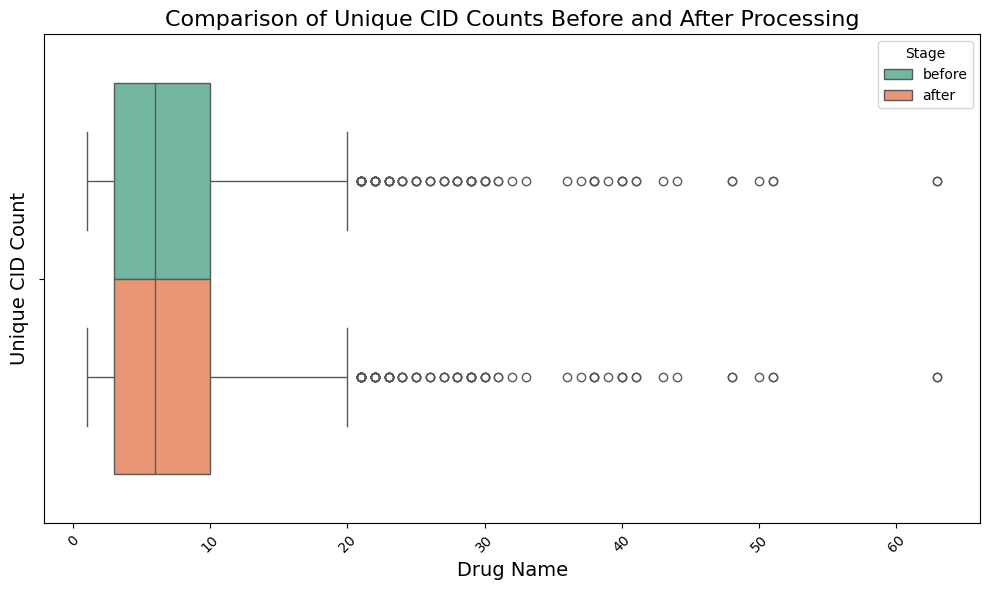

In [100]:

# Plot the paired box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=comparison_data_melted, x='Unique CID Count', hue='Stage', palette='Set2')

# Customize plot
plt.title('Comparison of Unique CID Counts Before and After Processing', fontsize=16)
plt.xlabel('Drug Name', fontsize=14)
plt.ylabel('Unique CID Count', fontsize=14)
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()

#### Drop Non-Predictor Columns

We remove any redundant column or columns that cannot be leveraged as a predictors for the 'Level' label.

In [101]:
# Columns to drop (non-predictors, excluding `cid_A` and `cid_B`)
columns_to_drop = ['Drug_A', 'Drug_B', 'Drug Name_x', 'Drug Name_y']

# Drop the columns except for `cid_A` and `cid_B` which will be kept as primary keys
ddinter_drugA_drugB_joined.drop(columns=columns_to_drop, inplace=True)

# Show the first few rows after dropping the columns
ddinter_drugA_drugB_joined.head()


,Level,cid_A,mw_A,polararea_A,complexity_A,xlogp_A,heavycnt_A,hbonddonor_A,hbondacc_A,rotbonds_A,...,monoisotopicmass_B,charge_B,covalentunitcnt_B,isotopeatomcnt_B,totalatomstereocnt_B,definedatomstereocnt_B,undefinedatomstereocnt_B,totalbondstereocnt_B,definedbondstereocnt_B,undefinedbondstereocnt_B
0,1,4428.0,341.4,70.0,621.0,1.9,25,2,5,2,...,286.154,0,1,0,2,0,2,0,0,0
1,1,4428.0,341.4,70.0,621.0,1.9,25,2,5,2,...,286.154,0,1,0,2,1,1,0,0,0
2,1,4428.0,341.4,70.0,621.0,1.9,25,2,5,2,...,384.122,0,2,0,2,1,1,0,0,0
3,1,4428.0,341.4,70.0,621.0,1.9,25,2,5,2,...,286.154,0,1,0,2,2,0,0,0,0
4,1,4428.0,341.4,70.0,621.0,1.9,25,2,5,2,...,670.276,0,3,0,4,4,0,0,0,0


In [102]:
ddinter_drugA_drugB_joined.shape

(3006320, 41)

In [103]:
# Group by Level and count the number of rows for each one
level_count_join = ddinter_drugA_drugB_joined.groupby('Level').size().reset_index(name='count')

level_count_join

,Level,count
0,0,265473
1,1,2273994
2,2,466853


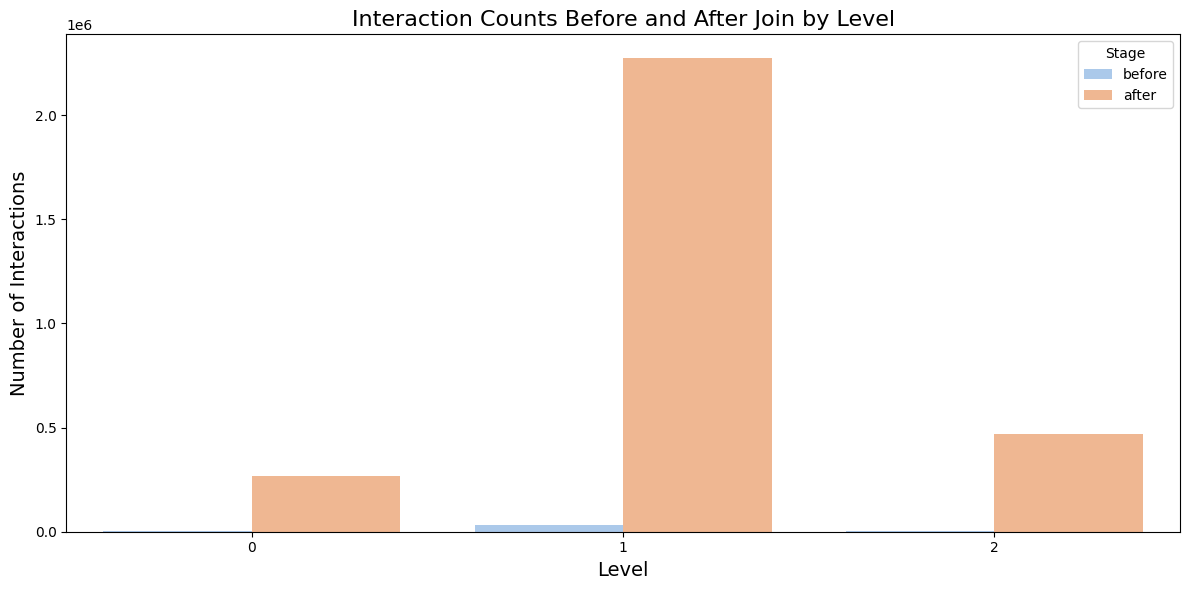

In [104]:
# Rename count columns for clarity
level_count = level_count.rename(columns={'count': 'before'})
level_count_join = level_count_join.rename(columns={'count': 'after'})

# Perform an outer join on the 'Level' column
comparison_data = pd.merge(level_count, level_count_join, on='Level', how='outer')

# Fill NaN values with 0 for missing levels
comparison_data.fillna(0, inplace=True)

# Melt the data for easier plotting with Seaborn
melted_comparison = comparison_data.melt(id_vars='Level', 
                                          value_vars=['before', 'after'],
                                          var_name='Stage', 
                                          value_name='Interaction Count')

# Create a grouped bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=melted_comparison, x='Level', y='Interaction Count', hue='Stage', palette='pastel')

# Add titles and labels
plt.title('Interaction Counts Before and After Join by Level', fontsize=16)
plt.xlabel('Level', fontsize=14)
plt.ylabel('Number of Interactions', fontsize=14)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


#### Data Cleaning

We check for missing values and decide to drop the 'xlogp' column because it has too many values missing and it is not easy to impute with standard methods. 

In [105]:
# Check for null values in each column of the DataFrame
null_values = ddinter_drugA_drugB_joined.isnull().sum()

# Display the columns with the number of null values
null_values


Level                            0
cid_A                            0
mw_A                             0
polararea_A                      0
complexity_A                     0
xlogp_A                     675673
heavycnt_A                       0
hbonddonor_A                     0
hbondacc_A                       0
rotbonds_A                       0
exactmass_A                      0
monoisotopicmass_A               0
charge_A                         0
covalentunitcnt_A                0
isotopeatomcnt_A                 0
totalatomstereocnt_A             0
definedatomstereocnt_A           0
undefinedatomstereocnt_A         0
totalbondstereocnt_A             0
definedbondstereocnt_A           0
undefinedbondstereocnt_A         0
cid_B                            0
mw_B                             0
polararea_B                      0
complexity_B                     0
xlogp_B                     803636
heavycnt_B                       0
hbonddonor_B                     0
hbondacc_B          

In [106]:
# Drop the 'xlogp_A' and 'xlogp_B' columns from the DataFrame
ddinter_drugA_drugB_joined.drop(columns=['xlogp_A', 'xlogp_B'], inplace=True)


#### Create a New Link Table for Future References

We may need this to make sense of the machine learning models later, so we can identifie each and one of the rows in terms of CID or Drug Name values.

In [107]:
# Create a new DataFrame for storing the connection between 'cid_A' and 'cid_B'
cid_connection_df = ddinter_drugA_drugB_joined[['cid_A', 'cid_B']].reset_index(drop=True)


---
### Train and Test Data Set Split

We use scikit-learn to perform a data split to get standard data sets for machine learning algorithms.

In [108]:

# Set up feature matrix (train_X) and target vector (train_y)
train_X = ddinter_drugA_drugB_joined.drop(columns=['Level', 'cid_A', 'cid_B'])  # Drop 'cid_A' and 'cid_B' from features
train_y = ddinter_drugA_drugB_joined['Level']  # The target is the 'Level' column

# Split the dataset into training and testing sets (train_X, train_y, test_X, test_y)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.2, random_state=42)



In [109]:
# Display the first few rows of the final training and testing sets without the 'cid_A' and 'cid_B' columns
X_train.head()

,mw_A,polararea_A,complexity_A,heavycnt_A,hbonddonor_A,hbondacc_A,rotbonds_A,exactmass_A,monoisotopicmass_A,charge_A,...,monoisotopicmass_B,charge_B,covalentunitcnt_B,isotopeatomcnt_B,totalatomstereocnt_B,definedatomstereocnt_B,undefinedatomstereocnt_B,totalbondstereocnt_B,definedbondstereocnt_B,undefinedbondstereocnt_B
2010276,472.50,212.0,704.0,34,6,13,9,472.1820,472.1820,0,...,481.168,0,1,0,2,0,2,1,1,0
363535,44.05,17.1,10.3,3,0,1,0,44.0262,44.0262,0,...,4111.120,0,1,0,30,30,0,0,0,0
2544705,1041.80,629.0,2110.0,58,3,38,12,1040.7100,1040.7100,-8,...,361.144,0,1,0,1,1,0,0,0,0
2049367,281.35,46.9,413.0,21,1,3,2,281.1530,281.1530,0,...,320.111,0,2,0,1,0,1,0,0,0
996317,359.40,96.8,469.0,25,1,6,7,359.1230,359.1230,0,...,392.200,0,1,0,8,7,1,0,0,0


In [110]:
X_test.head()

,mw_A,polararea_A,complexity_A,heavycnt_A,hbonddonor_A,hbondacc_A,rotbonds_A,exactmass_A,monoisotopicmass_A,charge_A,...,monoisotopicmass_B,charge_B,covalentunitcnt_B,isotopeatomcnt_B,totalatomstereocnt_B,definedatomstereocnt_B,undefinedatomstereocnt_B,totalbondstereocnt_B,definedbondstereocnt_B,undefinedbondstereocnt_B
2553991,293.40,39.8,440.0,22,0,2,2,293.153,293.153,0,...,822.405,0,1,0,9,9,0,4,4,0
2115702,416.50,95.9,619.0,30,2,6,10,416.231,416.231,0,...,141.931,0,3,0,0,0,0,0,0,0
1745423,408.00,55.2,463.0,27,1,5,6,407.174,407.174,0,...,241.123,0,2,0,1,0,1,0,0,0
1497638,270.40,37.3,418.0,20,1,2,0,270.162,270.162,0,...,747.477,0,1,0,18,18,0,0,0,0
2251875,323.35,93.1,486.0,23,2,6,6,323.145,323.145,0,...,361.180,0,1,0,2,0,2,0,0,0


In [111]:
y_train.head()

2010276    1
363535     1
2544705    1
2049367    1
996317     1
Name: Level, dtype: int64

In [112]:
y_test.head()

2553991    1
2115702    1
1745423    1
1497638    1
2251875    1
Name: Level, dtype: int64

In [113]:
# Display the connection DataFrame for later reference
cid_connection_df.head()


,cid_A,cid_B
0,4428.0,1971.0
1,4428.0,65140.0
2,4428.0,65141.0
3,4428.0,441300.0
4,4428.0,441384.0


#### Saving the Train and Test Data Sets as CSV

The main output of this Jupyter Notebook. We create the following files in a sub folder `data/train_test`:    
1. X_train.csv
2. y_train.csv
3. X_test.csv
4. y_test.csv

In [114]:
import os

# Create a shorter folder name for storing both the training and testing datasets
folder_name = "train_test"

# Define the full path for the subfolder
data_dir = os.path.join("data", folder_name)

# Make sure the directory exists, if not, create it
os.makedirs(data_dir, exist_ok=True)

# Save the datasets as CSV files without the index
X_train.to_csv(os.path.join(data_dir, 'X_train.csv'), index=False)
y_train.to_csv(os.path.join(data_dir, 'y_train.csv'), index=False)
X_test.to_csv(os.path.join(data_dir, 'X_test.csv'), index=False)
y_test.to_csv(os.path.join(data_dir, 'y_test.csv'), index=False)

# Confirm that the files have been saved
print("Training and testing data saved successfully in the 'train_test' folder without indices!")


Training and testing data saved successfully in the 'train_test' folder without indices!


#### Full Merged Data Frame

We can save the complete merged DataFrame as a CSV if needed, but it's not recommended. The outpu file will be over 1 GB in size and can't be easily used  or uploaded to GitHub.

In [115]:
# # Save the final DataFrame as a CSV file in the 'data' folder
# output_path = "data/final_joined_data.csv"
# ddinter_drugA_drugB_joined.to_csv(output_path, index=False)

# # Confirm that the file has been saved
# import os
# os.path.exists(output_path)
